In [1]:
import os
import sys

In [2]:
os.getcwd()

'C:\\Users\\asi40\\Documents\\w251_Final_Project\\FP_model'

In [3]:
if "projects" not in os.getcwd():
  !git clone --depth 1 https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
  os.chdir('Yet-Another-EfficientDet-Pytorch')
  sys.path.append('.')
else:
  !git pull

fatal: destination path 'Yet-Another-EfficientDet-Pytorch' already exists and is not an empty directory.


In [4]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess, preprocess_video

In [5]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [6]:
model = torch.load("logs/asl/efficientdet-d0_29_5600.pth")

C:\Users\asi40\AppData\Local\Temp\ipykernel_2772\4291326836.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)


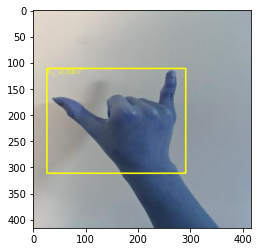

In [7]:
compound_coef = 0
force_input_size = None  # set None to use default size
#img_path = 'datasets/logo/val/208.jpg'
img_path = 'datasets/asl/val/Y10_jpg.rf.9b8787e8dd62ba25402dfb7e5b386bd9.jpg'

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

#obj_list = [ 'car', 'light' ]

obj_list = labels

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(1.0, 1.0), (1.3, 0.8), (1.9, 0.5)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

#model.load_state_dict(torch.load('logs/asl/'+weight_file[-1]))
model.load_state_dict(torch.load("logs/asl/efficientdet-d0_29_5600.pth"))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i])



### Detect in Real-Time

In [8]:
import cv2 
import numpy as np

In [9]:
# Setup capture
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [13]:
while True: 
    
    ret, frame = cap.read()

    #image_np = np.array(frame)
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #print(type(frame))
    
    threshold = 0.2
    iou_threshold = 0.2

    use_cuda = True
    use_float16 = False
    cudnn.fastest = True
    cudnn.benchmark = True

    #obj_list = [ 'car', 'light' ]

    obj_list = labels

    # tf bilinear interpolation is different from any other's, just make do
    input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
    input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
    ori_imgs, framed_imgs, framed_metas = preprocess_video(frame, max_size=input_size)
    
    #print(type(framed_imgs))

    if use_cuda:
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
    else:
        x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

    x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

    model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                                 # replace this part with your project's anchor config
                                 ratios=[(1.0, 1.0), (1.3, 0.8), (1.9, 0.5)],
                                 scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    #model.load_state_dict(torch.load('logs/asl/'+weight_file[-1]))
    model.load_state_dict(torch.load("logs/asl/efficientdet-d0_29_5600.pth"))
    model.requires_grad_(False)
    model.eval()

    if use_cuda:
        model = model.cuda()
    if use_float16:
        model = model.half()
    with torch.no_grad():
        features, regression, classification, anchors = model(x)

        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(x,
                          anchors, regression, classification,
                          regressBoxes, clipBoxes,
                          threshold, iou_threshold)

    out = invert_affine(framed_metas, out)

#     for i in range(len(ori_imgs)):
#         if len(out[i]['rois']) == 0:
#             continue
    ori_imgs = ori_imgs
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

            #plt.imshow(ori_imgs[i])


    print(obj, score)
    cv2.imshow("screen_title", frame)
    #cv2.imshow("screen_title", ori_imgs)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        break

C:\Users\asi40\AppData\Local\Temp\ipykernel_2772\1427831594.py:69: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)


J 0.668820321559906
J 0.6642786264419556
J 0.6878365278244019
J 0.6805298328399658
J 0.6365471482276917
J 0.5325393080711365
J 0.47926878929138184
J 0.5010231137275696
J 0.4385308623313904
J 0.46975448727607727
Q 0.3792315423488617
Q 0.2952573001384735
J 0.4443327486515045
J 0.5368754267692566
J 0.5780040621757507
J 0.6256163120269775
J 0.6349877715110779
J 0.4042744040489197
J 0.5415968298912048
Q 0.2542983591556549
J 0.47013235092163086
J 0.5128823518753052
Q 0.22022444009780884
J 0.6303701400756836
Q 0.23224341869354248
J 0.5946664214134216
Q 0.26546865701675415
J 0.4834486246109009
Q 0.24547907710075378
B 0.30260521173477173
Q 0.26965177059173584
Q 0.5165077447891235
W 0.32161247730255127
W 0.28498172760009766
W 0.2261085957288742
Z 0.23515217006206512
W 0.2969125211238861
J 0.24560266733169556
W 0.2596231997013092
N 0.31198325753211975
J 0.46596378087997437
Q 0.438190758228302
Q 0.5858834385871887
A 0.40417131781578064
Z 0.28415441513061523
G 0.28501349687576294
J 0.22361668944358

KeyboardInterrupt: 